In [68]:
import pandas as pd
import numpy as np
import Levenshtein
import geopandas as geopd
import seaborn as sns
from os import listdir
from os.path import isfile, join, splitext

# Reading geocoded data

In [69]:
path_data_geo =  '../../data/interim/Brazil/election_data/2018/polling_places/polling_places.csv'
data_geo = pd.read_csv(path_data_geo)
data_geo.head(1)

,id_unico,local_unico,lat,lon,fetched_address,precision,LOCAL_VOTACAO,ENDERECO,CEP,COD_LOCALIDADE_IBGE,LOCALIDADE_LOCAL_VOTACAO,SGL_UF,ZONA,BAIRRO_ZONA_SEDE,LATITUDE_ZONA,LONGITUDE_ZONA,NUM_SECAO,NUM_LOCAL,BAIRRO_LOCAL_VOT,COUNTRY
0,14385,"CRECHE DONA MARIA DE ARAUJO CARNEIRO, RUA NOSS...",-5.193051,-39.304486,"R. Dr. Sebastião Cavalcante, 58 - Monteiro de ...",ROOFTOP,CRECHE DONA MARIA DE ARAUJO CARNEIRO,RUA NOSSA SENHORA DA NATIVIDADE SN,62660000,2313757,UMIRIM,CE,23,CENTRO,NaN,NaN,231,1015,CENTRO-SEDE,BRASIL


# Creating query address to compare against fetched address

In [72]:
data_geo['query_address'] = data_geo['ENDERECO'] +', '+ data_geo['BAIRRO_LOCAL_VOT'] + ' - ' +  data_geo['LOCALIDADE_LOCAL_VOTACAO'] + ' - ' + data_geo['SGL_UF'] + ', ' + data_geo['CEP'].astype('str') + ', Brasil'

# Calculating levenshtein distance between query address and fetched address

In [107]:
data_geo['lev_dist'] = data_geo.apply(lambda x: Levenshtein.ratio(x['query_address'].lower(),x['fetched_address'].lower()), axis=1)

# Verifying locations with high similarity between query and fetched addresses

Similaridade maior que 0.8: 28401


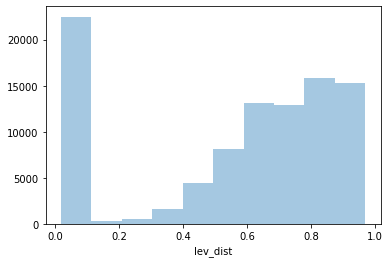

In [94]:
print('Similarity greater than 0.8:',sum(data_geo['lev_dist'] >= .8 ))
sns.distplot(data_geo['lev_dist'], bins = 10, kde=False)

# Verifying high similarity addresses considering only TSE precision
### Note: Locations with TSE precision were note queried, thus they do not present a fetched address attribute, which explains the low similarity results.

Lenght: 22348


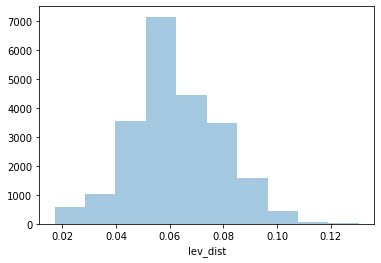

In [98]:
TSE_data_geo = data_geo[data_geo['precision'] == 'TSE']
print('Lenght:',len(TSE_data_geo))

sns.distplot(TSE_data_geo['lev_dist'], bins = 10, kde=False)

# Verifying high similarity addresses considering only ROOFTOP precision

Similarity greater than 0.8: 21451


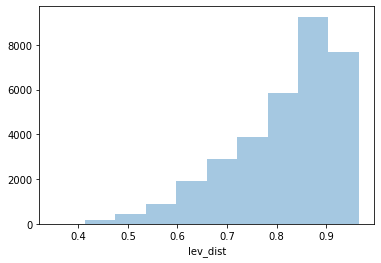

In [99]:
rooftop_data_geo = data_geo[data_geo['precision'] == 'ROOFTOP']
print('Similarity greater than 0.8:',sum(rooftop_data_geo['lev_dist'] >= .8 ))

sns.distplot(rooftop_data_geo['lev_dist'], bins = 10, kde=False)

# Verifying high similiarty addresses considering only Range Interpolated precision

Similarity greater than 0.8: 536


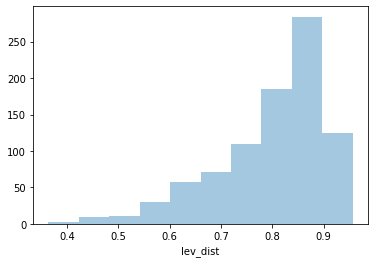

In [100]:
interpolated_data_geo = data_geo[data_geo['precision'] == 'RANGE_INTERPOLATED']
print('Similarity greater than 0.8:',sum(interpolated_data_geo['lev_dist'] >= .8 ))

sns.distplot(interpolated_data_geo['lev_dist'], bins = 10, kde=False)

# Verifying high similarity addresses considering only Geometric Center precision

Similarity greater than 0.8: 5975


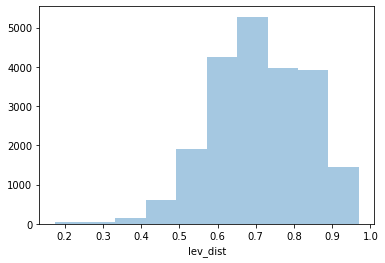

In [101]:
geometric_data_geo = data_geo[data_geo['precision'] == 'GEOMETRIC_CENTER']
print('Similarity greater than 0.8:',sum(geometric_data_geo['lev_dist'] >= .8 ))

sns.distplot(geometric_data_geo['lev_dist'], bins = 10, kde=False)

# Verifying high similarity addresses considering only Approximate precision

Similarity greater than 0.8: 439


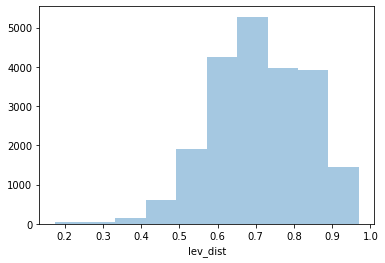

In [102]:
approximate_data_geo = data_geo[data_geo['precision'] == 'APPROXIMATE']
print('Similarity greater than 0.8:',sum(approximate_data_geo['lev_dist'] >= .8 ))

sns.distplot(geometric_data_geo['lev_dist'], bins = 10, kde=False)

# Number of locations which were not possible to geocode

In [108]:
no_value_data_geo = data_geo[data_geo['precision'] == 'NO_VALUE']
print('Lenght:',len(no_value_data_geo))

Lenght: 376


# Number of locations that cause error in the algorithm

In [105]:
error_data_geo = data_geo[data_geo['precision'] == 'ERROR']
print('Lenght:',len(error_data_geo))

Lenght: 0


# Total Number of locations with high similarity between query and fetched addresses

In [106]:
total_good_precision = sum(data_geo['lev_dist'] >= .8 ) + len(TSE_data_geo)
print('Number of locations with good precision:', total_good_precision)

Number of locations with good precision: 50749


In [10]:
data_geo['lat_4f'] = data_geo['lat'].map(lambda x: '{0:.4f}'.format(x))
data_geo['lon_4f'] = data_geo['lon'].map(lambda x: '{0:.4f}'.format(x))
data_geo['lat_lon'] = data_geo['lat_4f'].astype('str') +','+  data_geo['lon_4f'].astype('str')  

In [45]:
duplicated = data_geo.duplicated(subset='lat_lon', keep=False)
duplicated_data = data_geo[duplicated]
duplicated_data[duplicated_data['precision'] == 'ROOFTOP'].head(5)

,id_unico,local_unico,lat,lon,fetched_address,precision,LOCAL_VOTACAO,ENDERECO,CEP,COD_LOCALIDADE_IBGE,...,BAIRRO_ZONA_SEDE,LATITUDE_ZONA,LONGITUDE_ZONA,NUM_SECAO,NUM_LOCAL,BAIRRO_LOCAL_VOT,COUNTRY,lat_4f,lon_4f,lat_lon
0,14385,"CRECHE DONA MARIA DE ARAUJO CARNEIRO, RUA NOSS...",-5.193051,-39.304486,"R. Dr. Sebastião Cavalcante, 58 - Monteiro de ...",ROOFTOP,CRECHE DONA MARIA DE ARAUJO CARNEIRO,RUA NOSSA SENHORA DA NATIVIDADE SN,62660000,2313757,...,CENTRO,NaN,NaN,231,1015,CENTRO-SEDE,BRASIL,-5.1931,-39.3045,"-5.1931,-39.3045"
43,12040,"COLÉGIO ESTADUAL PROFESSOR RENATO AZEVEDO, AV....",-22.893081,-42.045681,"Av. América Central, Nº 0 - São Cristóvão, Cab...",ROOFTOP,COLÉGIO ESTADUAL PROFESSOR RENATO AZEVEDO,AV. AMERICA CENTRAL S/N,28909580,3300704,...,CENTRO,NaN,NaN,431,2100,SÃO CRISTÓVÃO,BRASIL,-22.8931,-42.0457,"-22.8931,-42.0457"
101,44831,"ESCOLA ESTADUAL DE PORTO AGRARIO, PRACA SAO PE...",-19.004377,-41.537856,"R. Cel. Farias, 218 - Centro, Galiléia - MG, 3...",ROOFTOP,ESCOLA ESTADUAL DE PORTO AGRARIO,PRACA SAO PEDRO,39467000,3136959,...,CENTRO,NaN,NaN,67,1040,CENTRO,BRASIL,-19.0044,-41.5379,"-19.0044,-41.5379"
140,64118,"ESCOLA MUNICIPAL MACHADO DE ASSIS, VILA CANADÁ...",-5.521833,-47.456081,"Rua Euclides Cunha, 200-302 - Parque Santa Luc...",ROOFTOP,ESCOLA MUNICIPAL MACHADO DE ASSIS,VILA CANADÁ - AGUA LIMA,65395000,2102036,...,CENTRO - ZONA URBANA,NaN,NaN,199,1368,VILA CANADÁ - ZONA RURAL,BRASIL,-5.5218,-47.4561,"-5.5218,-47.4561"
147,11187,"COLÉGIO ESTADUAL DE SERROLÂNDIA, PRAÇA DR. ANT...",-11.413721,-40.301799,"Tv. 1A G. Moreira, 1 - Centro, Serrolândia - B...",ROOFTOP,COLÉGIO ESTADUAL DE SERROLÂNDIA,"PRAÇA DR. ANTÔNIO CARLOS MAGALHÃES, S/N",44710000,2930600,...,CENTRO,NaN,NaN,337,1015,CENTRO,BRASIL,-11.4137,-40.3018,"-11.4137,-40.3018"
